In [1]:
import os

os.chdir("..")

In [2]:
# Select GPUs to use
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5,6,7'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
import random
import time
import datetime

# Evaluation
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix
)

# Transformers
import torch
from torch.nn import BCEWithLogitsLoss, DataParallel
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import RAdam
from transformers import BertTokenizerFast, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup 
import wandb

from src.data.iterative_train_test_split import iterative_train_test_split
from src.models.evaluation import evaluation
from src.models.transformer_training import train_epoch, calculate_pos_weights, format_time

In [4]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [5]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

In [6]:
# Use GPU
torch.cuda.empty_cache()
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [26]:
# Use wandb for hyperparameter optimization and training visualization
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jonathanbt (use `wandb login --relogin` to force relogin)


True

## 1. Load and transform data

In [7]:
# Load data
df = pd.read_pickle("data/processed/reports_tokenized.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 HOLDINGS PLC\n\nANNUAL REPORT & ACCOUNTS 2020\n\n A YEAR OF \nSTRONG GROWTH \n\n888 IS ONE ...,888 ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH ORG IS ONE OF THE WORLDS LEADING O...,org annual report account year strong growth org one world leading online betting gaming company...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on \nour Promises\n\n2020 Corporate Social Responsibility Report\n\n1\n\n Letter fro...,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8101,8101,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,sustainability report company profile corporate overview purpose mission value sustainability co...
8102,8102,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,sustainability report investing future world letter ceo stakeholder company profile corporate ov...


In [8]:
# Transform labels to numpy array: Exclude SDGs 2 and 9 (too few aligned examples) and 10 and 14 (no mapping) -> 13 labels left
labels = [
    "SDG_1",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

In [9]:
# Split into 70% training, 15% validation, and 15% test data (stratified for multi-label, adapted to work with df column)

np.random.seed(7)

X_train, Y_train, X_test, Y_test = iterative_train_test_split(df['CSR_Text_clean'], Y, test_size=0.3)
X_val, Y_val, X_test, Y_test = iterative_train_test_split(X_test, Y_test, test_size=0.5)

In [10]:
# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained("models/esgbert")

In [11]:
# Encode data (LongformerForSequenceClassification automatically sets global_attention_mask such that global attention is on the CLS token, no need to specify)
train_encodings = tokenizer(list(X_train), max_length=512, truncation=True, padding=True, return_tensors="pt")
val_encodings = tokenizer(list(X_val), max_length=512, truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(list(X_test), max_length=512, truncation=True, padding=True, return_tensors="pt")

In [12]:
# Convert data into TensorDatasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(Y_train).float())
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(Y_val).float())
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(Y_test).float())

In [32]:
# Create the DataLoader

batch_size = 16 #8, 32
    
train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle = True)

In [35]:
# Check encoding example

# Print the original sentence.
print('Original: ', X_train[3][1998:2051])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(X_train[3][1998:2051]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X_train[3][1998:2051])))

Original:  enthusiastic approach to sustainability and our drive
Tokenized:  ['enthusiastic', 'approach', 'to', 'sustainability', 'and', 'our', 'drive']
Token IDs:  [14727, 3921, 2000, 15169, 1998, 2256, 3298]


In [36]:
# Check DataLoader
next(iter(train_dataloader))

[tensor([[  101,  8917,  2760,  ...,  1010,  2164,   102],
         [  101,  2760, 15169,  ...,  3623,  2256,   102],
         [  101,  5971,  9068,  ...,  1999,  2760,   102],
         ...,
         [  101,  8917,  1012,  ...,  2023,  3189,   102],
         [  101,  2852,  4921,  ..., 26438,  2135,   102],
         [  101,  8917, 10476,  ...,  3438,  2005,   102]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([[0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0.],
         [0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.],
         [0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.],
         [0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0.],
         [0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.],
         [0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 1., 1., 

## 2. Hyperparameter tuning

In [33]:
# Define input parameters for training

epochs = 10

# Parameters to test in grid search using wandb
sweep_config = {
    'method': 'grid',
    'metric': {'name': 'BCELoss', 
               'goal': 'minimize'},
    'parameters': {'learning_rate': {'values': [1e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 1e-4]},
                   'weight_decay': {'values': [0, 0.01, 0.0001]}},
    'early_terminate': {'type': 'hyperband', "min_iter": 3}
    }

sweep_id = wandb.sweep(sweep_config, project="esgbert_512_16")

Create sweep with ID: j9kci9wx
Sweep URL: https://wandb.ai/jonathanbt/esgbert_512_16/sweeps/j9kci9wx


In [34]:
# Train
def train(config=None):
    
    # Initialize a new wandb run
    with wandb.init(config=config):
        
        # Set parameters to test
        config = wandb.config
        
        # Load model
        model = BertForSequenceClassification.from_pretrained("models/esgbert", problem_type="multi_label_classification", num_labels=13, ignore_mismatched_sizes=True)
        model.to(device)
        
        # Use BCEWithLogitsLoss instead of CrossEntropyLoss
        pos_weight = calculate_pos_weights(Y_train)
        loss_fct_train = BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
        loss_fct_val = BCEWithLogitsLoss()

        # Create the optimizer
        optimizer = RAdam(model.parameters(), lr=config.learning_rate, weight_decay=0)
        
        # Create the learning rate scheduler (linear decreasing lr without warmup)
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = len(train_dataloader) * epochs)
        
        # Train and store metrics
        for epoch in range(epochs):
            avg_train_loss, avg_val_loss, avg_val_f1 = train_epoch(model, optimizer, scheduler, train_dataloader, val_dataloader, loss_fct_train, loss_fct_val, device)
            wandb.log({"avg_train_loss": avg_train_loss, "avg_val_loss": avg_val_loss, "avg_val_f1": avg_val_f1, "epoch": epoch})    

wandb.agent(sweep_id, train)

wandb: Agent Starting Run: lzz5kmy6 with config:
wandb: 	learning_rate: 2e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at models/esgbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([26, 768]) in the checkpoint and torch.Size([13, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([26]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


avg_train_loss,█▇▆▄▃▃▂▂▁▁
avg_val_f1,▁▃▃▆▇▇▆███
avg_val_loss,█▅▄▄▁▂▃▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
avg_train_loss,0.17726
avg_val_f1,0.72807
avg_val_loss,0.50871
epoch,9


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h5u0g33h with config:
wandb: 	learning_rate: 3e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at models/esgbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([26, 768]) in the checkpoint and torch.Size([13, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([26]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


avg_train_loss,█▇▅▄▃▃▂▂▁▁
avg_val_f1,▃▁▂▄▃█▇█▇█
avg_val_loss,▇█▇▄█▂▂▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█
avg_train_loss,0.13261
avg_val_f1,0.74093
avg_val_loss,0.50472
epoch,9


wandb: Agent Starting Run: 93pxw5cs with config:
wandb: 	learning_rate: 4e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: ERROR Error communicating with wandb process
wandb: ERROR try: wandb.init(settings=wandb.Settings(start_method='fork'))
wandb: ERROR or:  wandb.init(settings=wandb.Settings(start_method='thread'))
wandb: ERROR For more info see: https://docs.wandb.ai/library/init#init-start-error
Run 93pxw5cs errored: UsageError("Error communicating with wandb process\ntry: wandb.init(settings=wandb.Settings(start_method='fork'))\nor:  wandb.init(settings=wandb.Settings(start_method='thread'))\nFor more info see: https://docs.wandb.ai/library/init#init-start-error")
wandb: ERROR Run 93pxw5cs errored: UsageError("Error communicating with wandb process\ntry: wandb.init(settings=wandb.Settings(start_method='fork'))\nor:  wandb.init(settings=wandb.Settings(start_method='thread'))\nFor more info see: https://docs.wandb.ai/library/init#init-start-error")


Problem at: /tmp/ipykernel_64151/4134251192.py 5 train


wandb: Agent Starting Run: tw3b8q2f with config:
wandb: 	learning_rate: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at models/esgbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([26, 768]) in the checkpoint and torch.Size([13, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([26]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


avg_train_loss,█▇▅▄▃▃▂▂▁▁
avg_val_f1,▁▃▂▆▆▇▆▇██
avg_val_loss,█▄▆▃▂▁▄▃▂▂
epoch,▁▂▃▃▄▅▆▆▇█
avg_train_loss,0.10254
avg_val_f1,0.76029
avg_val_loss,0.5112
epoch,9


wandb: Sweep Agent: Waiting for job.
wandb: Ctrl + C detected. Stopping sweep.


## 3. Retrain best model

In [37]:
# Load model
model = BertForSequenceClassification.from_pretrained("models/esgbert", problem_type="multi_label_classification", num_labels=13, ignore_mismatched_sizes=True)
#model = DataParallel(model)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at models/esgbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([26, 768]) in the checkpoint and torch.Size([13, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([26]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [38]:
# Prepare training

# Parameters
epochs = 10
learning_rate = 5e-5 
warumup_steps = 0

# Use BCEWithLogitsLoss instead of CrossEntropyLoss
pos_weight = calculate_pos_weights(Y_train)
loss_fct_train = BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
loss_fct_val = BCEWithLogitsLoss()

# Optimizer
optimizer = RAdam(model.parameters(), lr=learning_rate)

# Learning rate scheduler (linear decreasing lr without warmup)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warumup_steps, 
                                            num_training_steps = len(train_dataloader) * epochs)

In [39]:
# Training

# Store training and validation loss, validation F1 score, and timings
training_stats = []

# Measure the total training time for the whole run
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # Print progress update 
        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack the batch from the dataloader and copy each tensor to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch) and return the loss (because we provided labels) and the logits
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        logits = result.logits
        loss = loss_fct_train(logits, b_labels)

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0. to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
    
    predictions , true_labels = [], []

    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dataloader:
        
        # Unpack the batch from the dataloader and copy each tensor to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training)
        with torch.no_grad():        

            # Forward pass, calculate logit predictions
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model
        logits = result.logits
        loss = loss_fct_val(logits, b_labels)
            
        # Accumulate the validation loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)
        
    # Report the final macro F1 score for this validation run
    predicted_labels = torch.round(torch.sigmoid(torch.Tensor(np.concatenate(predictions, axis=0)))).numpy().astype(int)
    true_labels = np.concatenate(true_labels, axis=0).astype(int)
    avg_val_f1 = f1_score(predicted_labels, true_labels, average='macro')
    print("  Macro F1 score: {0:.2f}".format(avg_val_f1))    
    
    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Macro F1 score.': avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
    # Save model from best epoch (lowest validation loss)
    min_val_loss = 1
    # Get smallest validation loss
    for training_stat in training_stats:
        if training_stat['Valid. Loss'] < min_val_loss:
            min_val_loss = training_stat['Valid. Loss']
    if avg_val_loss == min_val_loss:
        # Save model (and overwrite previous model if it exists)
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, 'models/esgbert_512.pt')

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch   100  of    343.    Elapsed: 0:00:26.
  Batch   200  of    343.    Elapsed: 0:00:52.
  Batch   300  of    343.    Elapsed: 0:01:18.

  Average training loss: 0.53
  Training epoch took: 0:01:29

Running Validation...
  Macro F1 score: 0.59
  Validation Loss: 0.59
  Validation took: 0:00:07

======== Epoch 2 / 10 ========
Training...
  Batch   100  of    343.    Elapsed: 0:00:26.
  Batch   200  of    343.    Elapsed: 0:00:52.
  Batch   300  of    343.    Elapsed: 0:01:18.

  Average training loss: 0.44
  Training epoch took: 0:01:29

Running Validation...
  Macro F1 score: 0.60
  Validation Loss: 0.60
  Validation took: 0:00:07

======== Epoch 3 / 10 ========
Training...
  Batch   100  of    343.    Elapsed: 0:00:26.
  Batch   200  of    343.    Elapsed: 0:00:52.
  Batch   300  of    343.    Elapsed: 0:01:19.

  Average training loss: 0.37
  Training epoch took: 0:01:30

Running Validation...
  Macro F1 score: 0.74
  Validation Loss: 

In [40]:
# Look at training summary
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Macro F1 score.,Training Time,Validation Time
epoch,,,,,
1,0.534579,0.591835,0.589294,0:01:29,0:00:07
2,0.437091,0.596151,0.602599,0:01:29,0:00:07
3,0.372253,0.515953,0.737604,0:01:30,0:00:07
4,0.308791,0.575903,0.639746,0:01:29,0:00:07
5,0.239917,0.526276,0.736267,0:01:29,0:00:07
6,0.184264,0.527158,0.736648,0:01:29,0:00:07
7,0.150032,0.518584,0.739122,0:01:29,0:00:07
8,0.123924,0.521697,0.743246,0:01:29,0:00:07
9,0.105831,0.498189,0.764847,0:01:29,0:00:07


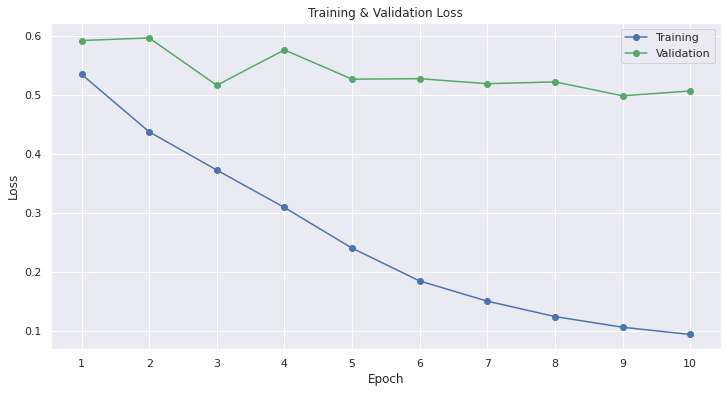

In [41]:
# Plot the learning curve

sns.set(style='darkgrid')
# sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(1,epochs+1)))

plt.show()

In [42]:
# Restore best model

checkpoint = torch.load('models/esgbert_512.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## 4. Predict on test set

In [43]:
model.eval()

predictions , true_labels = [], []

# Predict 
for batch in tqdm(test_dataloader):
    
    # Unpack the betch from the dataloader and copy each tensor to the GPU
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
  
    with torch.no_grad():
        # Forward pass: calculate logit predictions
        result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)
    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

# Transform output for further use
predicted_labels = torch.round(torch.sigmoid(torch.Tensor(np.concatenate(predictions, axis=0)))).numpy().astype(int)
true_labels = np.concatenate(true_labels, axis=0).astype(int)

  0%|          | 0/82 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.77      0.59      0.67       156
           1       0.90      0.77      0.83      1077
           2       0.86      0.69      0.77      1041
           3       0.88      0.84      0.86       981
           4       0.87      0.79      0.83      1011
           5       0.84      0.79      0.81       958
           6       0.85      0.81      0.83       899
           7       0.75      0.59      0.66       153
           8       0.91      0.84      0.87      1116
           9       0.81      0.77      0.79       828
          10       0.81      0.75      0.78       472
          11       0.85      0.84      0.85       930
          12       0.76      0.60      0.67       153

   micro avg       0.86      0.78      0.82      9775
   macro avg       0.83      0.74      0.79      9775
weighted avg       0.86      0.78      0.82      9775
 samples avg       0.79      0.74      0.74      9775



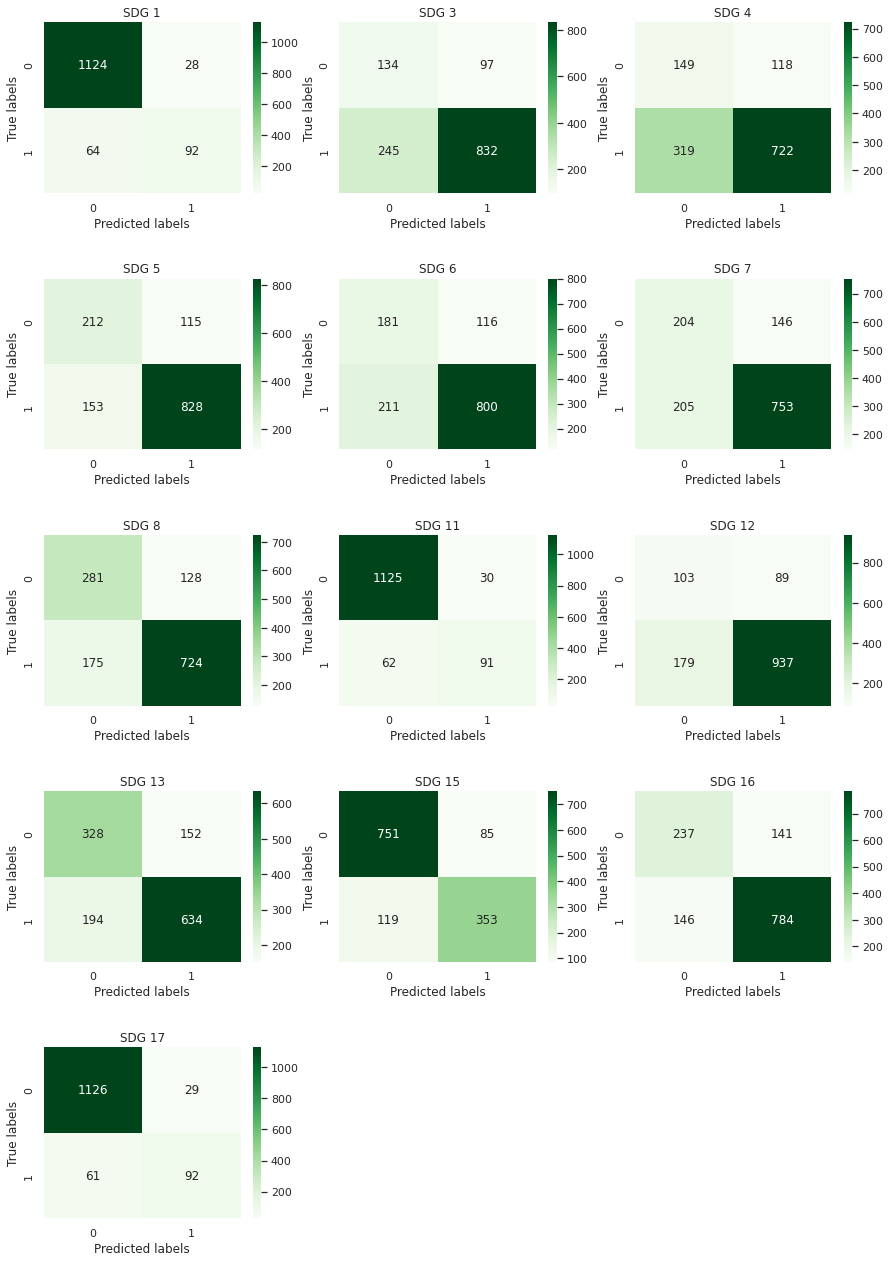

In [44]:
# Print classification report
print(classification_report(true_labels, predicted_labels))

# Plot confusion matrices for each label
sdgs = [1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17]
counter = 0
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 22))
plt.subplots_adjust(hspace=0.5)
for ax in axes.flatten():
    if counter <= 12:
        cm = confusion_matrix(true_labels[:, counter], predicted_labels[:, counter])
        sns.heatmap(cm, annot=True, fmt="g", ax=ax, cmap="Greens")
        ax.set_title("SDG " + str(sdgs[counter]))
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        counter += 1
    else:
        ax.set_visible(False)
        counter += 1